In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
class Wavelet(nn.Module):
    def __init__(self, num_layers, kernel_size, stride=1,
                 padding=1, dilation=1, groups=1):
        super(Wavelet, self).__init__()
        
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        
        self.weight_hi = nn.Parameter(torch.Tensor(1,1,kernel_size))
        self.weight_lo = nn.Parameter(torch.Tensor(1,1,kernel_size))
        
        self.weights = []
        self.weights.append(self.weight_hi) 
        for i in range(1,num_layers):
            self.weights.append(torch.Tensor(1,1,kernel_size*(2**i)))
        self.weights.append(torch.Tensor(1,1,kernel_size*2**(num_layers-1)))
        
        self.weights_dec = copy.deepcopy(self.weights)
        
        self.reset_parameters()

    def reset_parameters(self):
#         nn.init.xavier_uniform_(self.weight_hi)
#         nn.init.xavier_uniform_(self.weight_lo)
        self.weight_lo = nn.Parameter(torch.tensor([[[0.4830, 0.8365, 0.2241, -0.1294]]], dtype=torch.float32))
#         self.weight_hi = nn.Parameter(torch.tensor([[[-0.1294, -0.2241, 0.8365, -0.4830]]], dtype=torch.float32))
        idx = torch.arange(self.weight_lo.size(2)-1, -1, -1).long()
        weight_hi = self.weight_lo[:,:,idx]
        odd = torch.arange(1, self.weight_hi.size(2)-1, 2).long()
        weight_hi[:,:,odd] = weight_hi[:,:,odd]*-1
        self.weight_hi = nn.Parameter(weight_hi)
        
    def energy(self,tensor):
        return (tensor.pow(2).sum())
    
    def upsample(self,weigth, filt):
        kernel_size = weigth.shape[-1]
        filt_size = filt.shape[-1]
        upsampeled = torch.zeros((1,1,kernel_size*2-1))
        upsampeled[:,:,::2] = weigth
        upsampeled_pad = F.pad(upsampeled,(math.ceil(filt_size/2),math.floor(filt_size/2))) #padding
        return upsampeled, F.conv1d(upsampeled_pad, filt)
        
    def reset_weights_enc(self):
        self.weights[0] = self.weight_hi
        last_lo = self.weight_lo
        last_hi = self.weight_hi
        accumulated_lo = self.weight_lo
        for i in range(1,self.num_layers):
            last_hi, self.weights[i] = self.upsample(last_hi, accumulated_lo)
            last_lo, accumulated_lo = self.upsample(last_lo, accumulated_lo)
        self.weights[self.num_layers] = accumulated_lo
        for w in self.weights:
            plt.plot(np.linspace(0,1,w.size(2)),w.data.numpy()[0,0,:])
        
    def reset_weights_dec(self):
        for i,weight in enumerate(self.weights):            
            inv_idx = torch.arange(weight.size(2)-1, -1, -1).long()
            self.weights_dec[i] = weight[:,:,inv_idx]
#         for w in self.weights_dec:
#             print (w)

        
#     def batman(self,data_len,data):
#         center = data.size(2)//2
#         r_shift = center + math.floor(data_len/2)
#         l_shift = center - math.ceil(data_len/2)
#         return (data[:,:,l_shift:r_shift])

    def encoding(self,data):
        self.reset_weights_enc()
        encoding = torch.Tensor(data.size(0),self.num_layers+1,data.size(2))
        for i,weight in enumerate(self.weights):
            filt_size = weight.size(2)-1
            left = math.ceil(filt_size/2)
            rigth = math.floor(filt_size/2)
#             print (i,F.conv1d(F.pad(data,(left,rigth)), weight))
            encoding[:,i,:] = F.conv1d(F.pad(data,(left,rigth)), weight).squeeze(1)
        return encoding
    
    def decoding(self,encoding):
        self.reset_weights_dec()
        decoding = torch.zeros((encoding.size(0),1,encoding.size(2)))
        for i,weight in enumerate(self.weights_dec):
            filt_size = weight.size(2)-1
            left = math.floor(filt_size/2)
            rigth = math.ceil(filt_size/2)
#             tmp = F.conv1d(F.pad(encoding[:,i,:].unsqueeze(1),(left,rigth)), weight)
#             print (i, tmp)
            decoding += F.conv1d(F.pad(encoding[:,i,:].unsqueeze(1),(left,rigth)), weight)
        return decoding
        
        
        
    def forward(self,data):
        self.reset_weights_enc()
        encoding = torch.Tensor(data.size(0),self.num_layers+1,data.size(2))
        for i,weight in enumerate(self.weights):
            filt_size = weight.size(2)-1
            left = math.ceil(filt_size/2)
            rigth = math.floor(filt_size/2)
#             tmp = F.conv1d(F.pad(data,(math.ceil(filt_size/2),math.floor(filt_size/2))), weight)
            encoding[:,i,:] = F.conv1d(F.pad(data,(left,rigth)), weight).squeeze(1)
        return encoding
        
        

#     def forward(self, input):
#         return F.conv1d(input, self.weight, self.bias, self.stride,
#                         self.padding, self.dilation, self.groups)

tensor([[[ 180.0394,  255.6583,  335.1915,  313.5259,   95.8860,
            38.9170,  -12.8359,  -17.4320]]])


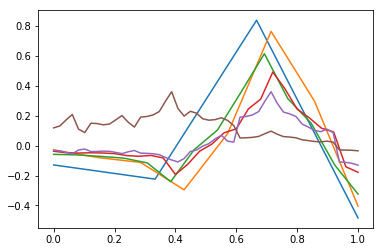

In [78]:
filters = torch.randn(1, 1, 10)
inputs = torch.tensor([[[80,80,80,80,0,0,0,0]]], dtype=torch.float32)
model = Wavelet(5,6)
encod = model.encoding(inputs)
dec = model.decoding(encod)
print (dec)

In [44]:
model.energy(model.weight_hi), model.energy(model.weight_lo)

(tensor(1.0000), tensor(1.0000))

In [206]:
arr = torch.zeros((1, 1, 7))              # array([1, 2, 3, 4, 5, 6])
torch.arange(arr.size(2)-1, -1, -1).long()

tensor([ 6,  5,  4,  3,  2,  1,  0])

In [55]:
kernel_size = 5
a = torch.tensor(range(5))+1
zeros = torch.zeros((1,1,kernel_size*2-1))
zeros[:,:,::2] = a
print (zeros)

tensor([[[ 1.,  0.,  2.,  0.,  3.,  0.,  4.,  0.,  5.]]])


In [108]:
low_fil = torch.Tensor([[[1,1]]] )
weigth = torch.Tensor([[[1,1]]] )
F.conv1d(weigth, low_fil,padding=3).shape
f_size = low_fil.shape[-1]

In [116]:
def upsample(weigth, filt):
    kernel_size = weigth.shape[-1]
    filt_size = filt.shape[-1]
    upsampeled = torch.zeros((1,1,kernel_size*2-1))
    upsampeled[:,:,::2] = weigth
    upsampeled = F.pad(upsampeled,(math.ceil(filt_size/2),math.floor(filt_size/2)))
    return F.conv1d(upsampeled, filt)
low_fil = torch.Tensor([[[-1,1]]] )
weigth = torch.Tensor([[[1,1]]] )
upsample(weigth,low_fil)

tensor([[[ 1., -1.,  1., -1.]]])

In [31]:
tensor = torch.rand(1,1,10) # your tensor
# tensor =torch.tensor([[[0.4830, 0.8365, 0.2241, -0.1294]]])
en = tensor.pow(2).sum()
scale = math.sqrt(en)
tensor = tensor/scale
print (tensor.pow(2).sum())

tensor(1.)


In [ ]:
        en = self.energy(self.weight_lo)
        scale = math.sqrt(en)
        self.weight_lo = nn.Parameter(self.weight_lo/scale
        nn.init.xavier_uniform_(self.weight_hi)